In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample


In [67]:
# Load the dataset (5000+ labeled tweets)
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
df = pd.read_csv(url)

# Keep only the required columns
df = df[['tweet', 'label']]
df.columns = ['review', 'sentiment']

# Show first few rows
df.head()


,review,sentiment
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [69]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove links
    text = re.sub(r'<.*?>+', '', text)                 # remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)               # remove words with numbers
    return text

# Apply the cleaning function
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()


,review,clean_review
0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is so...
1,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i cant use ca...
2,bihday your majesty,bihday your majesty
3,#model i love u take with u all the time in ...,model i love u take with u all the time in u...
4,factsguide: society now #motivation,factsguide society now motivation


In [71]:
# Separate majority and minority classes
df_majority = df[df.sentiment == 0]
df_minority = df[df.sentiment == 1]

# Upsample the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=len(df_majority), 
                                 random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Check new class balance
df_balanced['sentiment'].value_counts()


sentiment
0    29720
1    29720
Name: count, dtype: int64

In [73]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_balanced['clean_review'])
y = df_balanced['sentiment']


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Accuracy: 0.9552489905787349

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5899
           1       0.94      0.98      0.96      5989

    accuracy                           0.96     11888
   macro avg       0.96      0.96      0.96     11888
weighted avg       0.96      0.96      0.96     11888



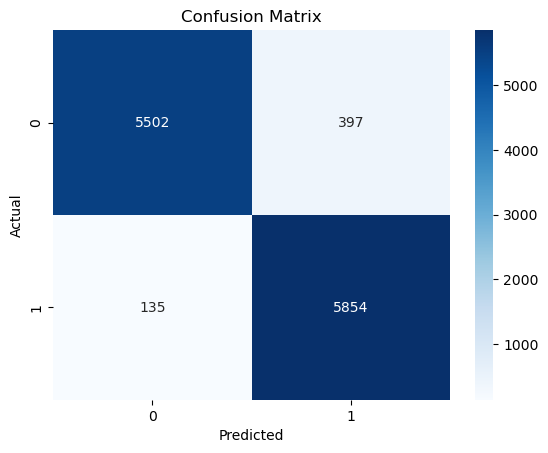

In [77]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
